# Combining snowfall detection procedure and snow compaction/temperature models

This notebook uses and combines the preliminary work done previously to see if models and procedures developed so far are consistent with observations.

### Imports

In [16]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy import f2py
import pandas as pd

In [3]:
import ddensity
import snowtemp

### Functions definition

In [4]:
def median_spacetime_filtering(ds, min_periods_val, time_window=11, x_span=11, y_span=11):
    '''
    Function to apply median filtering in time and space
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    # TODO take out time median
    # ds['snow_surface'] = ds['mean'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    # print(f'---> Median filtering in time with a window of {time_window}')
    ds['snow_surface'] = ds['mean'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


In [5]:

def get_snow_events(ds, x_sel, y_sel, time_window_std, time_window_mean, time_window_mean_diff, mean_diff_offset):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    Args:
        ds: clean dataset with 'snow_surface' variable
        x_sel: x coordinate of the point of interest (index)
        y_sel: y coordinate of the point of interest (index)
        time_window_std:
        time_window_mean:
        time_window_mean_diff:
        mean_diff_offset:
    Returns:
    '''
    # TODO finish commenting
    # TODO comment function better to explain what we do
    
    stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    mean_right_minus_mean_left = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=True).mean(dim='time') - ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=False).mean(dim='time')
    mean_right_minus_mean_left = mean_right_minus_mean_left.rolling(time=time_window_mean_diff, center=True).mean(dim='time').values

    snow_events_occurrences = stdev>0.02   # booleans
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        if mean_right_minus_mean_left[start_time_indices[index] + mean_diff_offset] >= 0:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


In [123]:
def get_change_in_snow_depth(ds, start_events, end_events, index_of_event, x_sel, y_sel):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
    Returns:
    '''
    # TODO finish commenting
    
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
    end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

### Define data

In [6]:
# Get data from files

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')


In [7]:
# Pre-processing to get clean data

data_dec_jan_feb = data_dec_jan_feb.ffill(dim='time')
median_spacetime_filtering(data_dec_jan_feb, 11)
data_dec_jan_feb['snow_surface'] = data_dec_jan_feb['snow_surface'] - data_dec_jan_feb['snow_surface'].min() 


---> Median filtering in space with a window [11, 11]


### Define parameters

In [146]:
# Defining parameters for snow events detection

x_sel = 11
y_sel = 11
time_window_std = 25
time_window_mean = 19
time_window_mean_diff = 51
mean_diff_offset = 20


In [252]:
# Initial state for compaction/temperature model, with 1 layers

ro_layer = np.zeros((20, 1))    # TODO adjust en fonction du nb de couches max
ro_layer[0] = 150
tf = 0
dt = 100
ro_water = 1000
ro_ice = 910
t_old = np.zeros((20, 1))
t_old[0] = -5
jj = 1
dy_snow = np.zeros((20, 1))
dy_snow[0] = 0.2
a1 = 0.0013
a2 = 0.021
gamma = np.zeros((20, 1))
gamma[0] = 0
tsfc = -15
cp_snow = 2.1
melt_flag = np.zeros((20, 1))
melt_flag[0] = 0


In [253]:
# Initialize arrays to keep track of variables in time

ro_layer_evolution = [ro_layer]
depth_evolution = [dy_snow]
temperature_evolution = [t_old]

### Get snow events timing

In [254]:

results = get_snow_events(data_dec_jan_feb, x_sel, y_sel, time_window_std, time_window_mean, time_window_mean_diff, mean_diff_offset)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]


/tmp/ipykernel_9689/2087010241.py:17: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
/tmp/ipykernel_9689/2087010241.py:19: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  mean_right_minus_mean_left = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=True).mean(dim='time') - ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_mean, center=False).mean(dim='time')
/tmp/ipykernel_9689/2087010241.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  mean_right_minus_mean_left = mean_right_minus_mean_left.rolling(time=time_window_mean_di

In [255]:

end_accumulation_times = data_dec_jan_feb.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - 1638796500000000000)/1000000000
# 1638796500000000000 is the first time point in data_dec_jan_feb
# TODO units ???

end_erosion_times = data_dec_jan_feb.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - 1638796500000000000)/1000000000

# print(end_accumulation_times, end_erosion_times)

### Simulate evolution of snowpack

In [256]:
# Update variables at each timepoint

accumulation_index = 0
erosion_index = 0

for i in range(70000):
    if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
        # TODO put all this in a function
        ddepth = get_change_in_snow_depth(data_dec_jan_feb, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
        ro_layer[jj] = 150
        t_old[jj] = -5
        dy_snow[jj] = ddepth  # ???
        gamma[jj] = 0
        melt_flag[jj] = 0
        jj += 1
        accumulation_index += 1
    
    if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
        # TODO put all this in a function
        ddepth = get_change_in_snow_depth(data_dec_jan_feb, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
        if dy_snow[jj-1] > ddepth:
            dy_snow[jj-1] = dy_snow[jj-1] - ddepth
        else:
            jj -= 1
            dy_snow[jj] = 0  # ???
            ro_layer[jj] = 0  # ???
            t_old[jj] = 0
            gamma[jj] = 0
            melt_flag[jj] = 0
        erosion_index += 1
    
    
    ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
    t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    ro_layer_evolution.append(ro_layer)
    depth_evolution.append(dy_snow)
    temperature_evolution.append(t_old)

### Plot evolution of snowpack, compare with lidar measurements

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'Density')

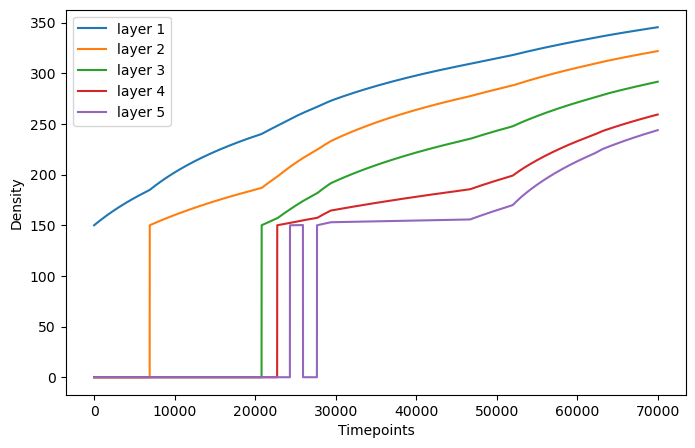

In [257]:
# Density

layer1 = [ro_layer_evolution[i][0] for i in range(len(ro_layer_evolution))]
layer2 = [ro_layer_evolution[i][1] for i in range(len(ro_layer_evolution))]
layer3 = [ro_layer_evolution[i][2] for i in range(len(ro_layer_evolution))]
layer4 = [ro_layer_evolution[i][3] for i in range(len(ro_layer_evolution))]
layer5 = [ro_layer_evolution[i][4] for i in range(len(ro_layer_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1')    # TODO specify if it's the top, middle or bottom layer
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Density')

Text(0, 0.5, 'Depth')

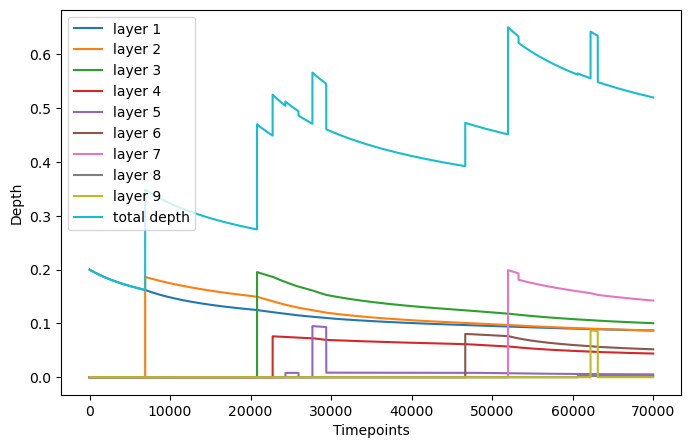

In [258]:
# Depth

layer1 = [depth_evolution[i][0] for i in range(len(depth_evolution))]
layer2 = [depth_evolution[i][1] for i in range(len(depth_evolution))]
layer3 = [depth_evolution[i][2] for i in range(len(depth_evolution))]
layer4 = [depth_evolution[i][3] for i in range(len(depth_evolution))]
layer5 = [depth_evolution[i][4] for i in range(len(depth_evolution))]
layer6 = [depth_evolution[i][5] for i in range(len(depth_evolution))]
layer7 = [depth_evolution[i][6] for i in range(len(depth_evolution))]
layer8 = [depth_evolution[i][7] for i in range(len(depth_evolution))]
layer9 = [depth_evolution[i][8] for i in range(len(depth_evolution))]
sum_layers = [layer1[i] + layer2[i] + layer3[i] + layer4[i] + layer5[i] + layer6[i] + layer7[i] + layer8[i] + layer9[i] for i in range(len(depth_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1')    # TODO specify if it's the top, middle or bottom layer
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.plot(layer6, label='layer 6')
plt.plot(layer7, label='layer 7')
plt.plot(layer8, label='layer 8')
plt.plot(layer9, label='layer 9')
plt.plot(sum_layers, label='total depth')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Depth')

Text(0, 0.5, 'Depth')

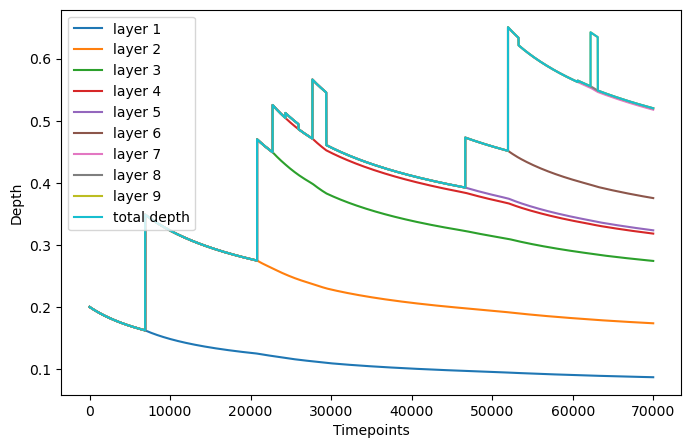

In [263]:
# Depth

layer1 = [depth_evolution[i][0] for i in range(len(depth_evolution))]
layer2 = [layer1[i] + depth_evolution[i][1] for i in range(len(depth_evolution))]
layer3 = [layer2[i] + depth_evolution[i][2] for i in range(len(depth_evolution))]
layer4 = [layer3[i] + depth_evolution[i][3] for i in range(len(depth_evolution))]
layer5 = [layer4[i] + depth_evolution[i][4] for i in range(len(depth_evolution))]
layer6 = [layer5[i] + depth_evolution[i][5] for i in range(len(depth_evolution))]
layer7 = [layer6[i] + depth_evolution[i][6] for i in range(len(depth_evolution))]
layer8 = [layer7[i] + depth_evolution[i][7] for i in range(len(depth_evolution))]
layer9 = [layer8[i] + depth_evolution[i][8] for i in range(len(depth_evolution))]
# sum_layers = [layer1[i] + layer2[i] + layer3[i] + layer4[i] + layer5[i] + layer6[i] + layer7[i] + layer8[i] + layer9[i] for i in range(len(depth_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1')    # TODO specify if it's the top, middle or bottom layer
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.plot(layer6, label='layer 6')
plt.plot(layer7, label='layer 7')
plt.plot(layer8, label='layer 8')
plt.plot(layer9, label='layer 9')
plt.plot(sum_layers, label='total depth')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Depth')

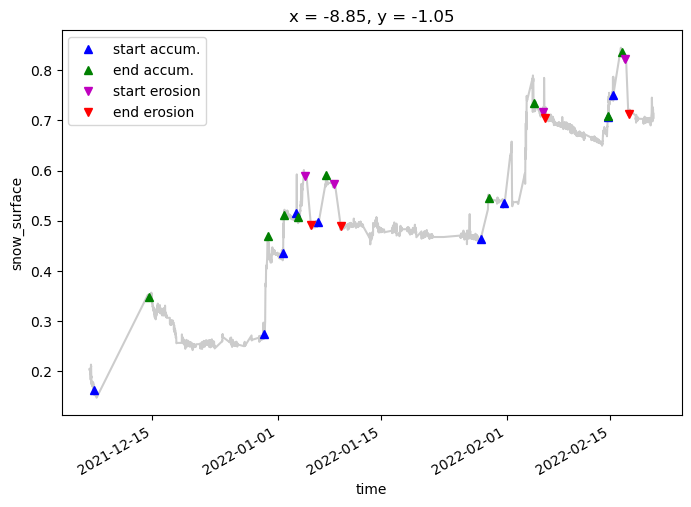

In [266]:
plt.figure(figsize=(8, 5))

data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)

data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')

simulated_times = [(i*dt + 1638796500000000000) * 1000000000]
# plt.plot(simulated_times, sum_layers, label='simulated snow depth')

plt.legend()


/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Comparison between lidar-measured and simulated snow depth')

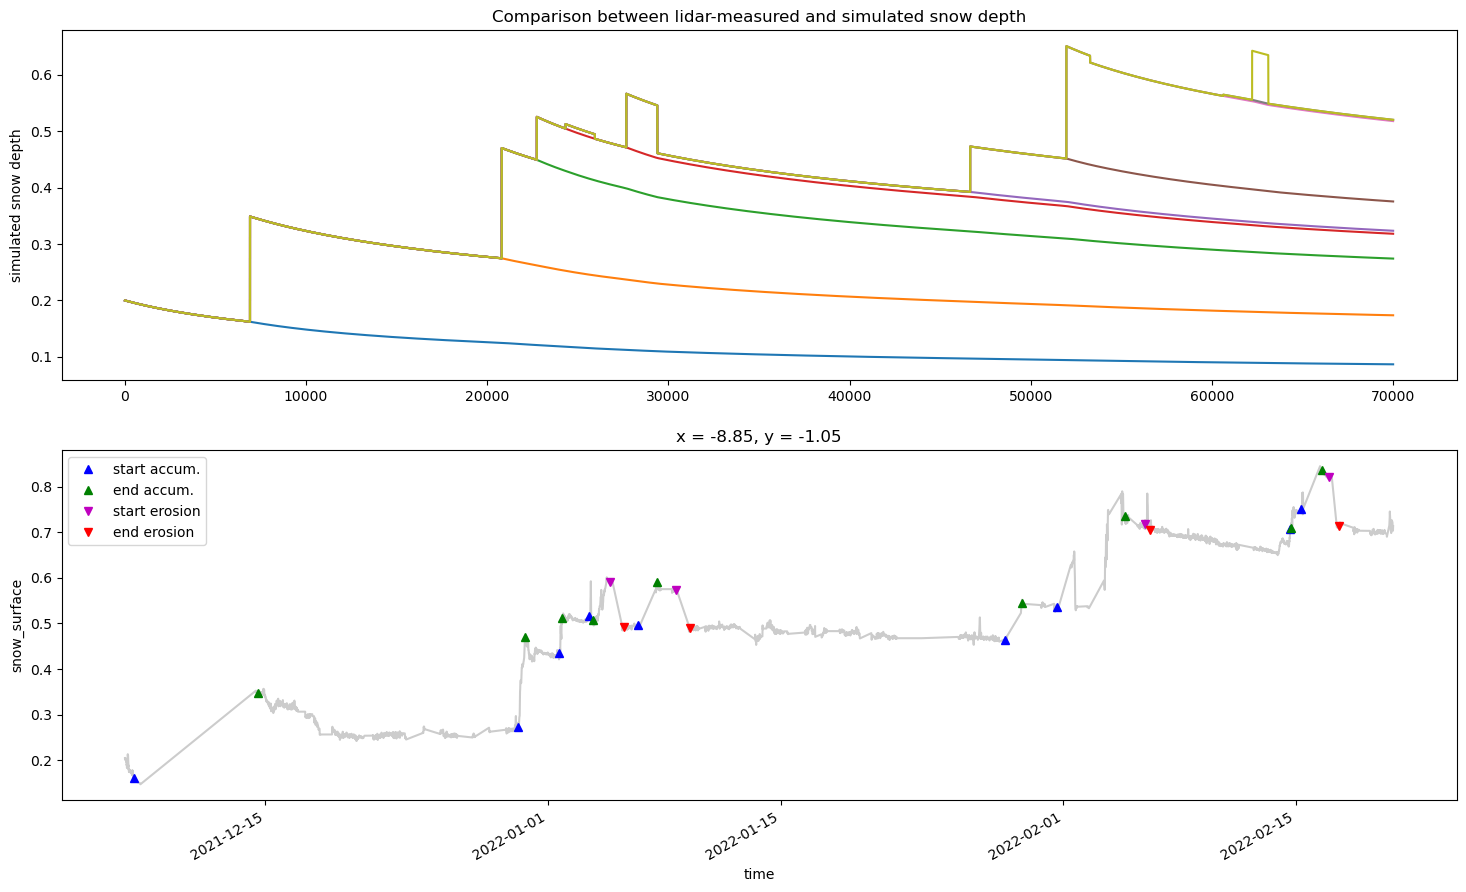

In [275]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(18, 10))

ax[0].plot(layer1, label='layer 1')
ax[0].plot(layer2, label='layer 2')
ax[0].plot(layer3, label='layer 3')
ax[0].plot(layer4, label='layer 4')
ax[0].plot(layer5, label='layer 5')
ax[0].plot(layer6, label='layer 6')
ax[0].plot(layer7, label='layer 7')
ax[0].plot(layer8, label='layer 8')
ax[0].plot(sum_layers, label='total depth')

ax[0].set_ylabel('simulated snow depth')

data_dec_jan_feb.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2, ax=ax[1])

data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.', ax=ax[1])
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.', ax=ax[1])
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion', ax=ax[1])
data_dec_jan_feb.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion', ax=ax[1])
ax[1].legend()

ax[0].set_title('Comparison between lidar-measured and simulated snow depth')

# fig.savefig('measured_vs_simul_snow_depth.png')

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'Temperature')

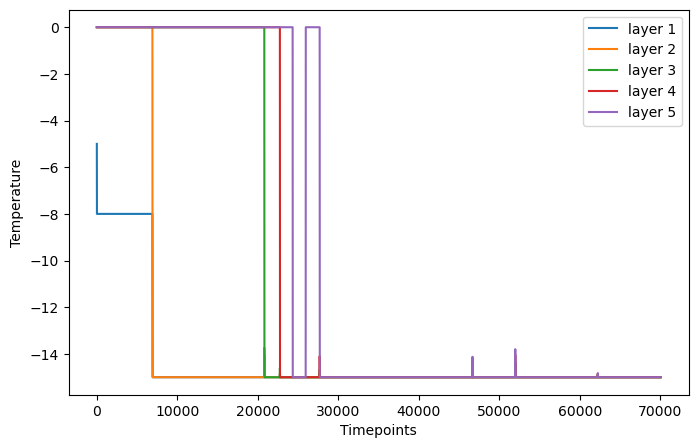

In [261]:
# Temperature

layer1 = [temperature_evolution[i][0] for i in range(len(temperature_evolution))]
layer2 = [temperature_evolution[i][1] for i in range(len(temperature_evolution))]
layer3 = [temperature_evolution[i][2] for i in range(len(temperature_evolution))]
layer4 = [temperature_evolution[i][3] for i in range(len(temperature_evolution))]
layer5 = [temperature_evolution[i][4] for i in range(len(temperature_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1')    # TODO specify if it's the top, middle or bottom layer
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Temperature')

In [219]:
# pas de temps sont trop grands pour temperature ?